<a href="https://colab.research.google.com/github/NittyNice/BADS7105-CRM-Analytics/blob/main/Campaign_response_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and config


## Mount google drive
Google Colab provides library to connect directly to Google Drive.  
Alternative way connection to the storage for loading and saving data files.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Use Linux command – <code>ls</code> to displays the contents of a directory.

In [13]:
!ls /content/gdrive/MyDrive/BADS7105_CRM

data  manytime_purchase_clustering.csv	onetime_purchase_clustering.csv


After checking that a directory exists, we create a variable <code>PATH</code> to contain the directory path.

In [14]:
PATH = "/content/gdrive/MyDrive/BADS7105_CRM"

## Import packages

In [66]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import plot_tree

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
%matplotlib inline

# Campaign Response Model

## Load the Customer Preference Survey dataset
In this work, we have stored the dataset in Google drive. Therefore, we will read the dataset from the directory where it is stored.  
You can load the dataset according to the directory where you store the them or others method.

In [16]:
# load data from Google Drive
df_response = pd.read_csv(PATH + '/data/Retail_Data_Response.csv')
df_transactions = pd.read_csv(PATH + '/data/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

# # load data from the same directory
# df_response = pd.read_csv('/data/Retail_Data_Response.csv')
# df_transactions = pd.read_csv('/data/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [17]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [18]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


## Data Preparation

### Find the range of date which transaction occurred and and choose the appropriate period.

In [19]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015. RFM model will be used to predict campaign response.

In [20]:
# Recency is calculated
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')

Times change, people's behaviors change. Therefore, we decided to use newer data than 2012.

In [21]:
df_transactions = df_transactions[df_transactions['trans_date'] > dt.datetime(2013,1,1)]

df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


### Create a dataset with the required features.

Create data set with RFM features.

In [22]:
# Create data set with RFM variables
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           

df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [23]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,7,463
1,CS1113,36.0,12,872
2,CS1114,33.0,12,856
3,CS1115,12.0,12,925
4,CS1116,204.0,6,392


Create data set with CLV features.

In [24]:
# Create data set with CLV variables
df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [25]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,7,463,684,66.142857
1,CS1113,36.0,12,872,705,72.666667
2,CS1114,33.0,12,856,756,71.333333
3,CS1115,12.0,12,925,775,77.083333
4,CS1116,204.0,6,392,598,65.333333


## Calculating response rate

In [26]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


You will find that the data is strongly imbalanced.

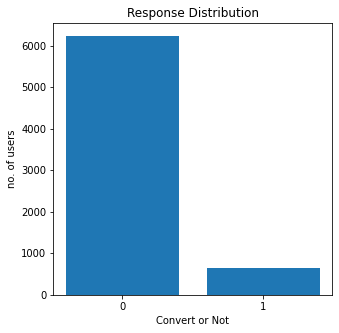

In [27]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

Merging two data sets - RFM

In [28]:
df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,7,463
1,CS1113,0,36.0,12,872
2,CS1114,1,33.0,12,856
3,CS1115,1,12.0,12,925
4,CS1116,1,204.0,6,392


Merging two data sets - CLV


In [29]:
df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,7,463,684,66.142857
1,CS1113,0,36.0,12,872,705,72.666667
2,CS1114,1,33.0,12,856,756,71.333333
3,CS1115,1,12.0,12,925,775,77.083333
4,CS1116,1,204.0,6,392,598,65.333333


## Creating train and test dataset

Spliting dataframe into X and y

In [30]:
X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

Creating train and test dataset

Note: you should create the train and test dataset first, then fixing the imbalanced data in train dataset. It'll maintain the test dataset to be similar to the real data.

In [31]:
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

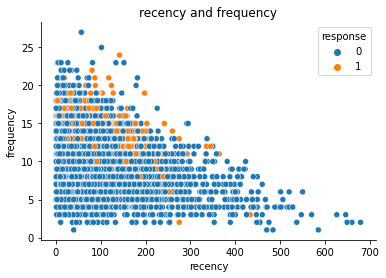

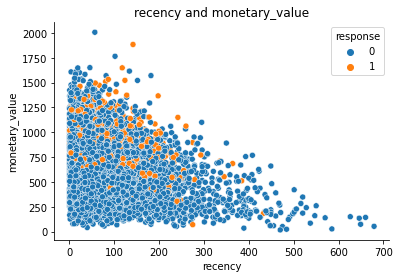

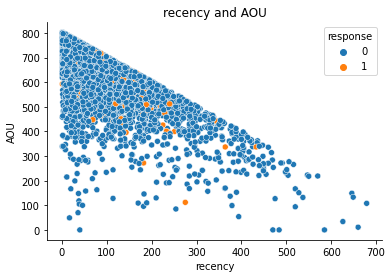

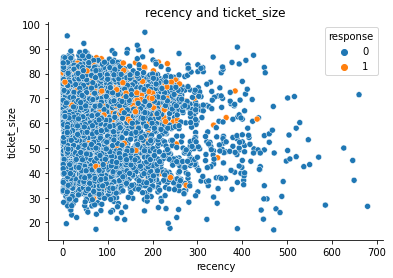

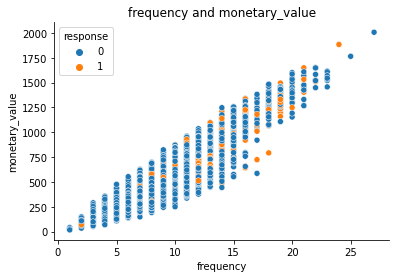

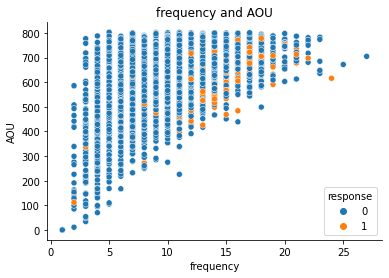

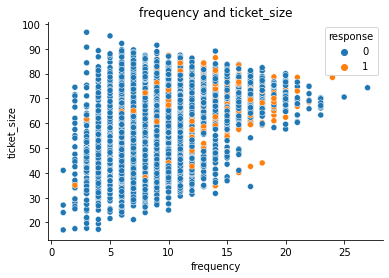

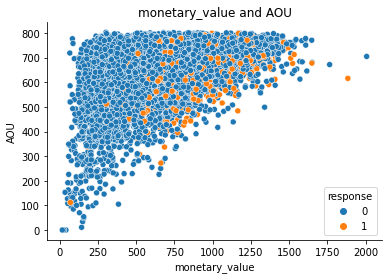

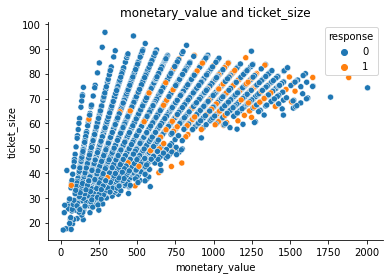

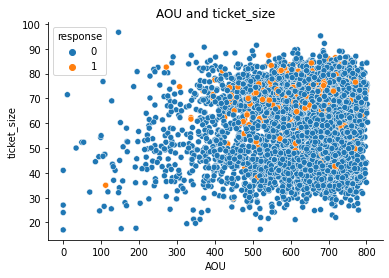

In [37]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

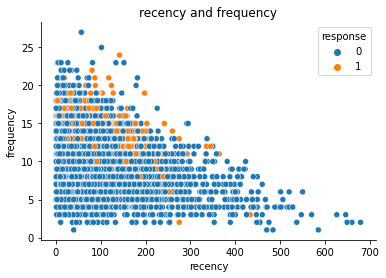

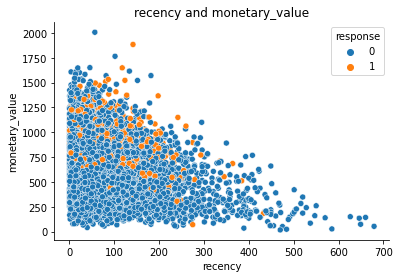

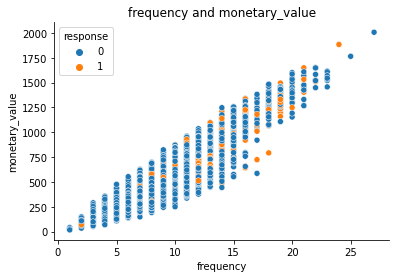

In [71]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## Fixing imbalanced with SMOTE

In [32]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## Model 1 : Logistic Regression

### RFM features

In [33]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      4389
           1       0.70      0.75      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

AUC Score 0.7116655274550012
test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.21      0.76      0.33       218

    accuracy                           0.68      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.68      0.74      2066

AUC Score 0.7115031375352476


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


<function matplotlib.pyplot.show>

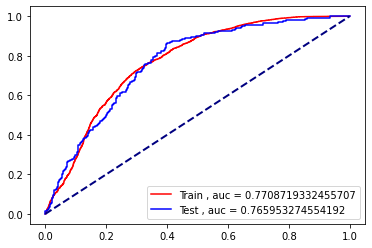

In [73]:
y_score_train = logreg_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm,y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train[:,1])
plt.plot(fpr_train,tpr_train,color='red',label = 'Train , auc = '+str(auc_train))

y_score_test = logreg_model_SMOTE_rfm.predict_proba(X_test_rfm.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv,y_score_test[:,1])
plt.plot(fpr_test,tpr_test,color='Blue',label = 'Test , auc = '+str(auc_test))

plt.plot([0,1],[0,1],color = 'navy', lw = 2,linestyle  = '--')
plt.legend(loc = 4)
plt.show

### CLV features

In [34]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      4389
           1       0.72      0.73      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

AUC Score 0.7232854864433812
test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.80      1848
           1       0.21      0.68      0.32       218

    accuracy                           0.69      2066
   macro avg       0.58      0.69      0.56      2066
weighted avg       0.87      0.69      0.75      2066

AUC Score 0.6873932642281265


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


<function matplotlib.pyplot.show>

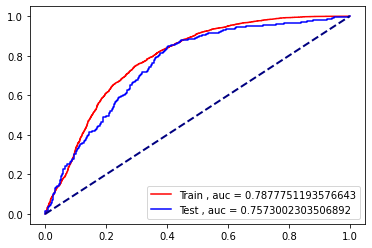

In [72]:
y_score_train = logreg_model_SMOTE_clv.predict_proba(X_SMOTE_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm,y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train[:,1])
plt.plot(fpr_train,tpr_train,color='red',label = 'Train , auc = '+str(auc_train))

y_score_test = logreg_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv,y_score_test[:,1])
plt.plot(fpr_test,tpr_test,color='Blue',label = 'Test , auc = '+str(auc_test))

plt.plot([0,1],[0,1],color = 'navy', lw = 2,linestyle  = '--')
plt.legend(loc = 4)
plt.show

## Model 2 : XGBoost

 ### RFM features

In [35]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm.to_numpy(), y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.750782
[2]	validation_0-auc:0.747567
[3]	validation_0-auc:0.732969
[4]	validation_0-auc:0.74472
[5]	validation_0-auc:0.750782
[6]	validation_0-auc:0.748536
Stopping. Best iteration:
[1]	validation_0-auc:0.750782

training set
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      4389
           1       0.70      0.80      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

AUC Score 0.7272727272727272
test set
              precision    recall  f1-score   support

           0       0.96      0.65      0.77      1848
           1       0.20      0.77      0.32       218

    accuracy                           0.66      2066
   macro avg       0.58      0.71      0.55      

<function matplotlib.pyplot.show>

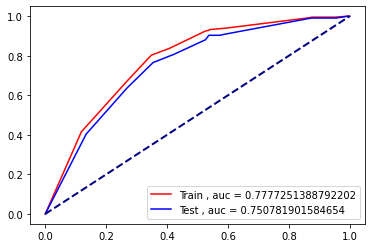

In [45]:
y_score_train = xgb_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm,y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train[:,1])
plt.plot(fpr_train,tpr_train,color='red',label = 'Train , auc = '+str(auc_train))

y_score_test = xgb_model_SMOTE_rfm.predict_proba(X_test_rfm.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_rfm,y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv,y_score_test[:,1])
plt.plot(fpr_test,tpr_test,color='Blue',label = 'Test , auc = '+str(auc_test))

plt.plot([0,1],[0,1],color = 'navy', lw = 2,linestyle  = '--')
plt.legend(loc = 4)
plt.show

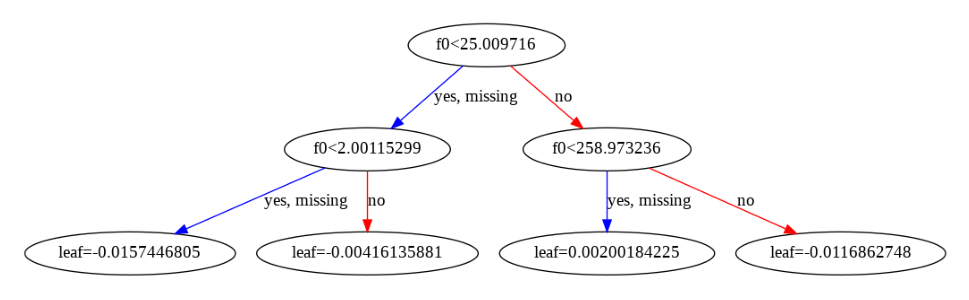

In [68]:
# display tree
fig = plt.figure(dpi=200)
ax = plt.subplot(1,1,1)

plot_tree(xgb_model_SMOTE_rfm, ax=ax)
plt.show()

 ### CLV features

In [36]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=150,
 max_depth=3,
 gamma=0.1,
 colsample_bytree=0.7)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv.to_numpy(), y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.766419
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.777576
[2]	validation_0-auc:0.778048
[3]	validation_0-auc:0.775152
[4]	validation_0-auc:0.779774
[5]	validation_0-auc:0.774856
[6]	validation_0-auc:0.775548
[7]	validation_0-auc:0.773476
[8]	validation_0-auc:0.770341
[9]	validation_0-auc:0.771769
Stopping. Best iteration:
[4]	validation_0-auc:0.779774

training set
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      4389
           1       0.69      0.83      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.74      0.73      0.73      8778
weighted avg       0.74      0.73      0.73      8778

AUC Score 0.7289815447710184
test set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      1848
           1       0.20      0.80      0.32       218

    accuracy

<function matplotlib.pyplot.show>

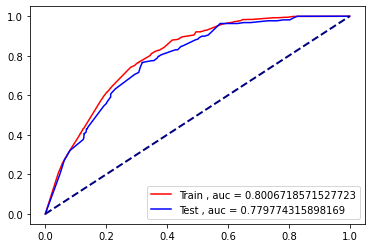

In [42]:
y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv,y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train[:,1])
plt.plot(fpr_train,tpr_train,color='red',label = 'Train , auc = '+str(auc_train))

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv,y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv,y_score_test[:,1])
plt.plot(fpr_test,tpr_test,color='Blue',label = 'Test , auc = '+str(auc_test))

plt.plot([0,1],[0,1],color = 'navy', lw = 2,linestyle  = '--')
plt.legend(loc = 4)
plt.show

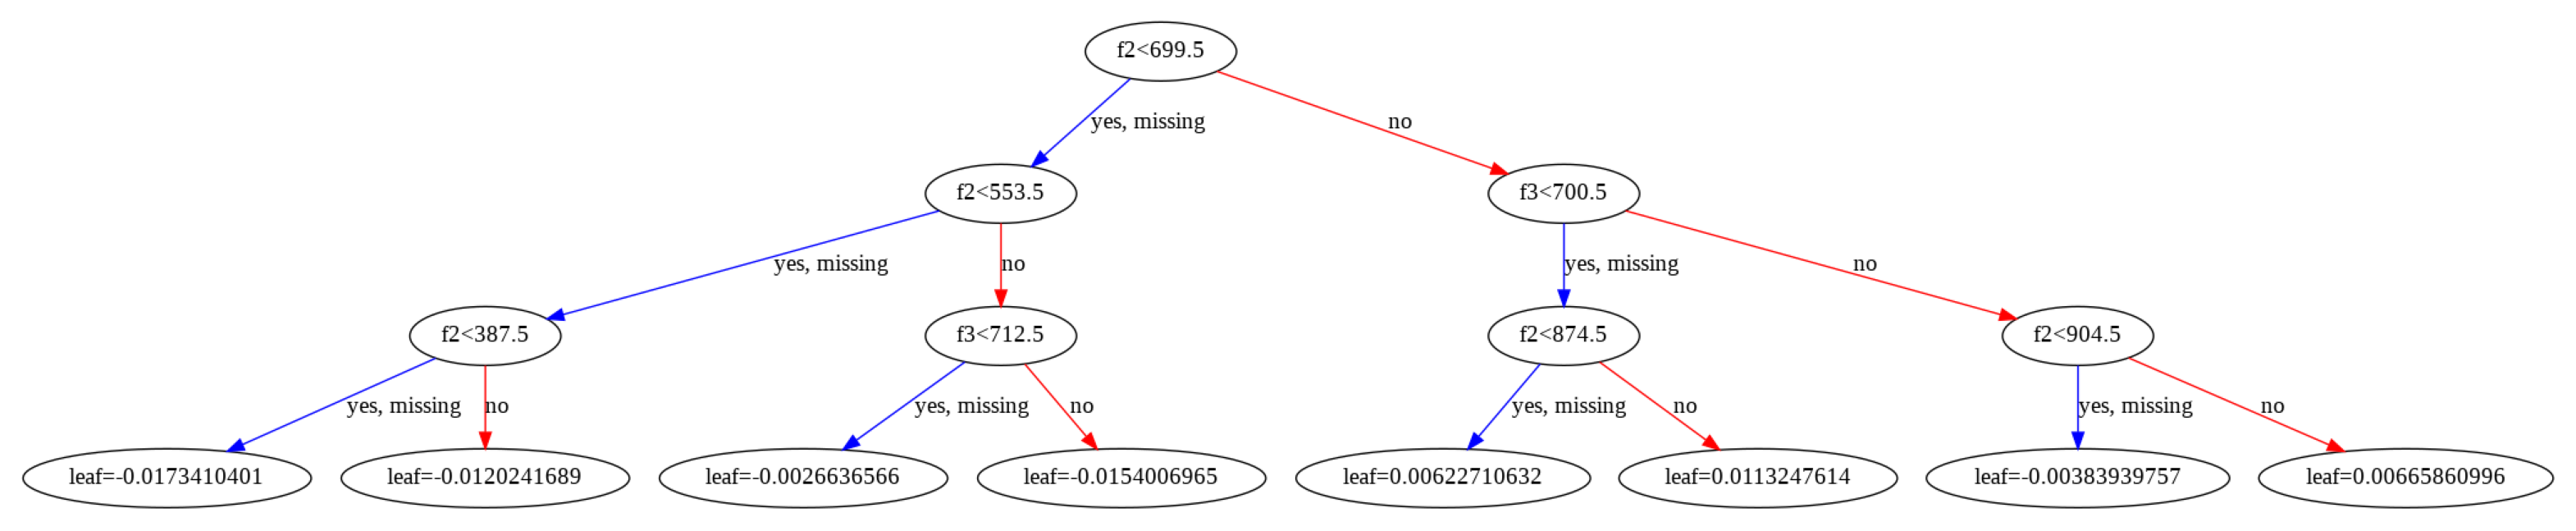

In [65]:
# display tree
fig = plt.figure(dpi=200)
ax = plt.subplot(1,1,1)

plot_tree(xgb_model_SMOTE_clv, ax=ax)
plt.show()

## **Hyper parameter tuning - Grid search**

building pipeline for hyperparameter tuning

In [38]:
# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

### Grid search

In [39]:
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [ ]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.706981077472437
Accuracy: 0.6108422071636012
[[1097  751]
 [  53  165]]
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.69      2066



### AUC curve

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  "X does not have valid feature names, but"


<function matplotlib.pyplot.show>

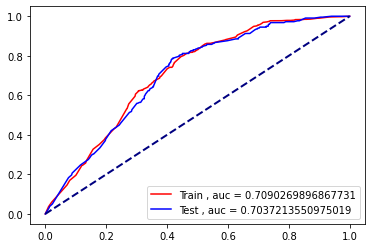

In [ ]:
y_score_train = xgb_model_clv_GS.predict_proba(X_SMOTE_clv.to_numpy())
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv,y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv,y_score_train[:,1])
plt.plot(fpr_train,tpr_train,color='red',label = 'Train , auc = '+str(auc_train))

y_score_test = xgb_model_clv_GS.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv,y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv,y_score_test[:,1])
plt.plot(fpr_test,tpr_test,color='Blue',label = 'Test , auc = '+str(auc_test))

plt.plot([0,1],[0,1],color = 'navy', lw = 2,linestyle  = '--')
plt.legend(loc = 4)
plt.show

In [ ]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'clf__reg_alpha': 0.01, 'clf__reg_lambda': 0.001, 'clf__subsample': 0.6, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f237ff4db90>}
